In [7]:
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgb
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer

pd.set_option('display.max_columns', None)

from importlib import reload
import run_models, output, process_df
from run_models import create_and_fit_regression_rf, create_and_fit_regression_lgb, create_and_fit_regression_nn, create_regression_lgb, build_nn_model, get_regression_cv_metrics, get_regression_cv_predictions
from output import output_metrics, print_train_history, print_metrics, print_graphs
reload(run_models)
reload(output)
reload(process_df)
from run_models import create_and_fit_regression_rf, create_and_fit_regression_lgb, create_and_fit_regression_nn, create_regression_lgb, build_nn_model, get_regression_cv_metrics, get_regression_cv_predictions
from output import output_metrics, print_train_history, print_metrics, print_graphs

In [8]:
with open(f'outliers/final/nan_filled_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
X = pd.concat([X_train, X_test, X_val])
y = np.concatenate([y_train, y_test, y_val])

In [9]:
def print_formatted(obj):
    for p in obj:
        val = obj[p]
        val = val if isinstance(val, int) or isinstance(val, float) else f'\'{val}\''
        print(f'{p}={val},')

def print_output(obj):
    for p in obj:
        print(f'{p}: {obj[p]}')
   
def print_formatted_params(params):
    print_formatted(convert_lgb_params(params))

In [10]:
def convert_lgb_params(params):
    objectives = ['mse', 'mae', 'huber', 'fair', 'quantile', 'mape']

    get_float = lambda val: max(min(val, 1), 0)
    get_int = lambda val: int(round(val))
    get_objective = lambda i: objectives[max(min(get_int(i), 5), 0)]

    return_params = {
        'tree_learner':'data',
        'verbose': -1,
        'n_jobs': -1,
        'objective': get_objective(params['objective']),
        'reg_lambda': params['reg_lambda'],
    }
    int_params = ['num_leaves', 'max_depth', 'min_data_in_leaf', 'min_child_samples', 'bagging_freq', 'n_estimators', 'min_sum_hessian_in_leaf']
    float_params = ['learning_rate', 'feature_fraction', 'bagging_fraction', 'subsample', 'min_child_weight', 'colsample_bytree', 'reg_alpha']
    for param in int_params:
        return_params[param] = get_int(params[param])
    for param in float_params:
        return_params[param] = get_float(params[param])
    return return_params

In [11]:
# Finetune with bayesian optimizer
def bayes_parameter_opt_lgb_regression(X, y, init_round=15, opt_round=30, n_folds=10, patience=30, validation_size=0.05, output_process=False):
    def model_eval(**params_raw):
        params = convert_lgb_params(params_raw)
        print(params)
        cv_result = get_regression_cv_metrics(create_and_fit_lgb_regressor_with_params, X, y, 
            n_splits=n_folds, patience=patience, validation_size=validation_size, regressor_params=params)
        return -cv_result['cv_metrics']['smape']

    pbounds = {
        'objective': (0, 5),
        'num_leaves': (10, 150),
        'learning_rate': (0.007, 1.0),
        'feature_fraction': (0.6, 1.0),
        'bagging_fraction': (0.75, 1),
        'max_depth': (0, 80),
        'min_data_in_leaf': (1, 80),
        'min_sum_hessian_in_leaf':(0,100),
        'subsample': (0.1, 1.0),
        'n_estimators': (1000, 20000),
        'min_child_samples': (1, 250),
        'min_child_weight': (0.1, 0.5),
        'bagging_freq': (1, 100),
        'colsample_bytree': (0.01, 1),
        'reg_alpha': (0, 1),
        'reg_lambda': (0, 100),
    }

    bounds_transformer = SequentialDomainReductionTransformer()
    optimizer = BayesianOptimization(
        f = model_eval, 
        pbounds = pbounds, 
        random_state=0,
        bounds_transformer=bounds_transformer,
    )
    optimizer.maximize(init_points=init_round, n_iter=opt_round)
    model_params=[]
    for model in range(len(optimizer.res)):
        model_params.append(optimizer.res[model]['target'])
    return {
        'target': optimizer.res[pd.Series(model_params).idxmax()]['target'], 
        'params': optimizer.res[pd.Series(model_params).idxmax()]['params'],
        'bounds_transformer': bounds_transformer,
        'optimizer': optimizer,
    }

In [ ]:
%%time
opt_results = bayes_parameter_opt_lgb_regression(X, y, init_round=30, opt_round=100, n_folds=10, patience=30)

In [ ]:
print_formatted_params(opt_results['params'])

In [12]:
# Finetune with hyperopt
from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform

def get_data():
    with open(f'outliers/final/nan_filled_data.pickle', 'rb') as handle:
        data = pickle.load(handle)
    X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
    X = pd.concat([X_train, X_test, X_val])
    y = np.concatenate([y_train, y_test, y_val])
    return X, y

def get_lgb_hyperas_model(X, y):
    objective={{uniform(0, 5)}}
    num_leaves={{uniform(10, 150)}}
    learning_rate={{uniform(0.005, 1.0)}}
    feature_fraction={{uniform(0.6, 1.0)}}
    bagging_fraction={{uniform(0.75, 1)}}
    max_depth={{uniform(0, 80)}}
    min_data_in_leaf={{uniform(1, 80)}}
    min_sum_hessian_in_leaf={{uniform(0,100)}}
    subsample={{uniform(0.1, 1.0)}}
    n_estimators={{uniform(1000, 20000)}}
    min_child_samples={{uniform(1, 250)}}
    min_child_weight={{uniform(0.1, 0.5)}}
    bagging_freq={{uniform(1, 100)}}
    colsample_bytree={{uniform(0.01, 1)}}
    reg_alpha={{uniform(0, 1)}}
    reg_lambda={{uniform(0, 100)}}
    
    params_raw = {
        'objective': objective,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'max_depth': max_depth,
        'min_data_in_leaf': min_data_in_leaf,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'subsample': subsample,
        'n_estimators': n_estimators,
        'min_child_samples': min_child_samples,
        'min_child_weight': min_child_weight,
        'bagging_freq': bagging_freq,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
    }
    params = convert_lgb_params(params_raw)
    print(params)
    cv_result = get_regression_cv_metrics(create_and_fit_lgb_regressor_with_params, X, y, 
            n_splits=10, patience=30, validation_size=0.05, regressor_params=params)
    return {'loss': cv_result['cv_metrics']['smape'], 'status': STATUS_OK} 

In [13]:
best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=get_lgb_hyperas_model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=trials,
                                      notebook_name='regression_lgm',
                                      eval_space=True,
                                      return_space=True,
                                      functions=[convert_lgb_params, get_regression_cv_metrics, create_and_fit_lgb_regressor_with_params])

>>> Imports:
#coding=utf-8

try:
    import pickle
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import lightgbm as lgb
except:
    pass

try:
    import time
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.preprocessing import PowerTransformer
except:
    pass

try:
    from sklearn.compose import TransformedTargetRegressor
except:
    pass

try:
    from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
except:
    pass

try:
    from importlib import reload
except:
    pass

try:
    import run_models, output, process_df
except:
    pass

try:
    from run_models import create_and_fit_regression_rf, create_and_fit_regression_lgb, create_and_fit_regression_nn, create_regression_lgb, build_nn_model, get_regression_cv_metrics, get_regression_cv_predictions
except:
    pass

try:
    from output import output_metrics, print_train_hi

NameError: name 'KFold' is not defined

In [13]:
def create_and_fit_lgb_regressor_with_params(X, y, X_val, y_val, patience=30, regressor_params=None):
    start = time.time()
    model = TransformedTargetRegressor(
        Pipeline([
            ('powertransform', PowerTransformer()),
            ('model', lgb.LGBMRegressor(**regressor_params)),
        ]),
        PowerTransformer(),
    ).fit(X.values, y,
        model__verbose=-1,
        model__eval_set=(X_val.values, y_val),
        model__early_stopping_rounds=patience,
        model__eval_metric='mean_absolute_error',
    )
    end = time.time()
    print(f'model fit time: {end - start}')
    return model

def create_regression_lgb():
    return lgb.LGBMRegressor(
        tree_learner='data',
        verbose=-1,
        n_jobs=-1,
        objective='mse',
        reg_lambda=0.435,
        num_leaves=98,
        max_depth=52,
        min_data_in_leaf=20,
        min_child_samples=4,
        bagging_freq=3,
        n_estimators=7149,
        min_sum_hessian_in_leaf=47,
        learning_rate=0.018,
        feature_fraction=0.665,
        bagging_fraction=0.8,
        subsample=0.231,
        min_child_weight=0.148,
        colsample_bytree=0.984,
        reg_alpha=0.617,
    )

def create_and_fit_lgb_regressor(X, y, X_val, y_val, patience=30, regressor_params={}):
    start = time.time()
    model = TransformedTargetRegressor(
        Pipeline([
            ('powertransform', PowerTransformer()),
            ('model', create_regression_lgb()),
        ]),
        PowerTransformer(),
    ).fit(X.values, y,
        model__verbose=-1,
        model__eval_set=(X_val.values, y_val),
        model__early_stopping_rounds=patience,
        model__eval_metric='mean_absolute_error',
    )
    end = time.time()
    print(f'model fit time: {end - start}')
    return model

split 1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[780]	valid_0's l1: 8.92623e+07	valid_0's l2: 3.84649e+16
model fit time: 14.96575665473938
train
smape: 22.900
mape: 45.652
mae: 10,360,827.000
rmse: 32,528,558.000
adj_r2: 0.946
test
smape: 55.913
mape: 223.153
mae: 23,321,903.000
rmse: 56,213,559.000
adj_r2: 0.779


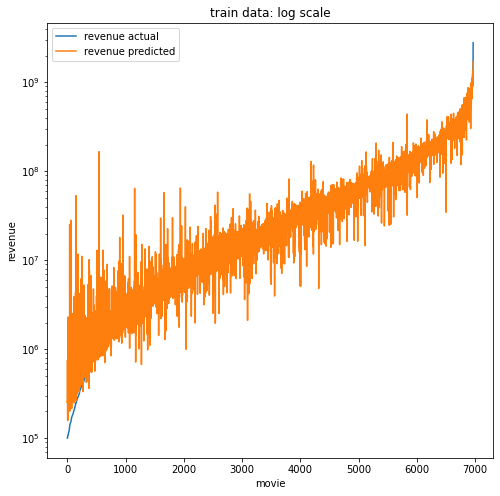

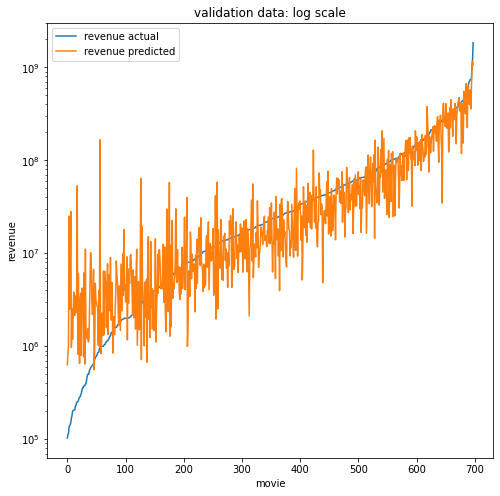

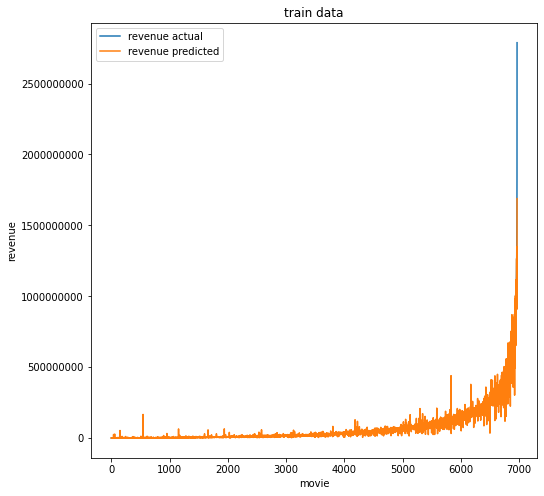

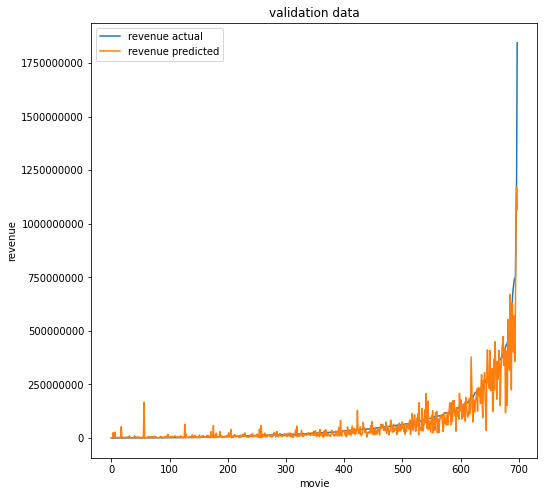

split 2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[674]	valid_0's l1: 6.61149e+07	valid_0's l2: 1.73591e+16
model fit time: 11.929806470870972
train
smape: 25.506
mape: 46.688
mae: 11,596,310.000
rmse: 35,127,050.000
adj_r2: 0.937
test
smape: 58.490
mape: 170.117
mae: 29,034,313.000
rmse: 68,763,563.000
adj_r2: 0.728


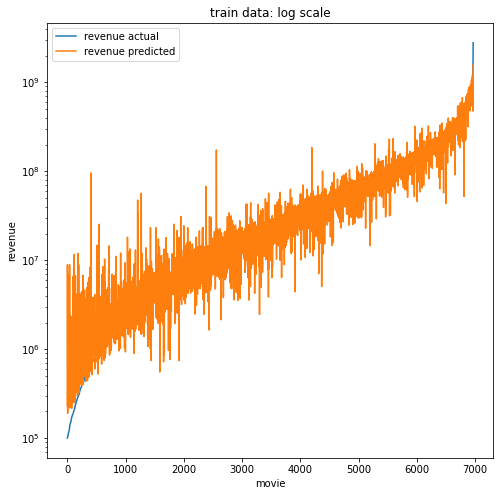

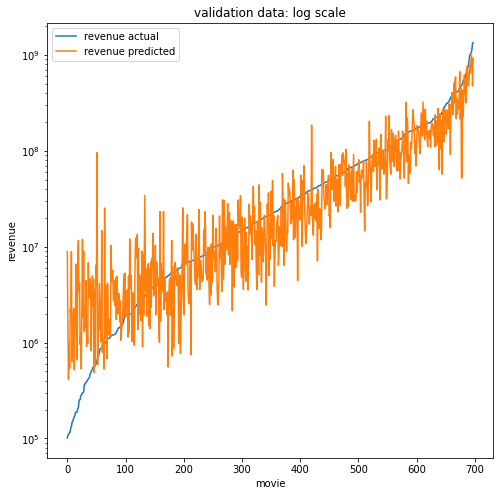

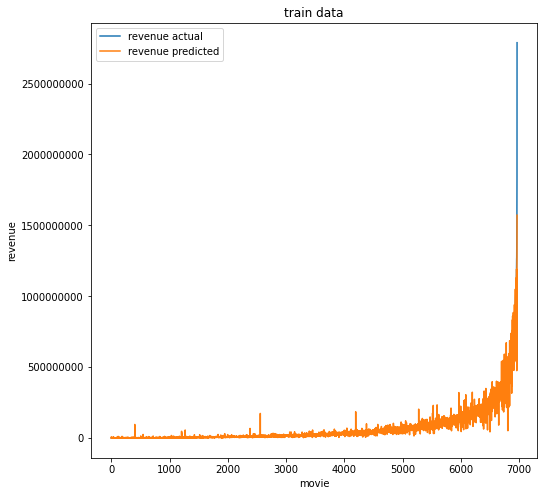

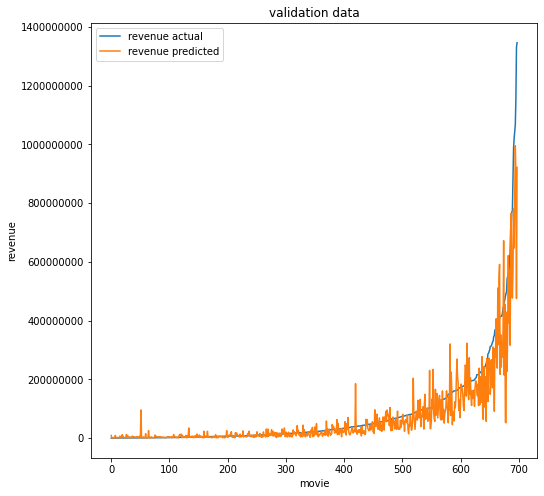

split 3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[726]	valid_0's l1: 6.62066e+07	valid_0's l2: 1.89954e+16
model fit time: 15.987421751022339
train
smape: 24.387
mape: 41.033
mae: 10,768,792.000
rmse: 30,901,492.000
adj_r2: 0.951
test
smape: 54.887
mape: 133.224
mae: 23,668,066.000
rmse: 48,796,633.000
adj_r2: 0.795


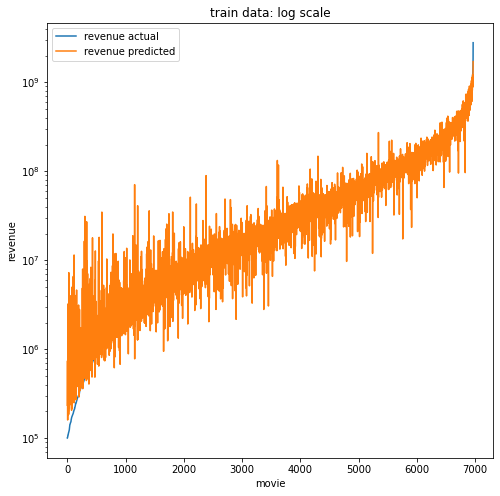

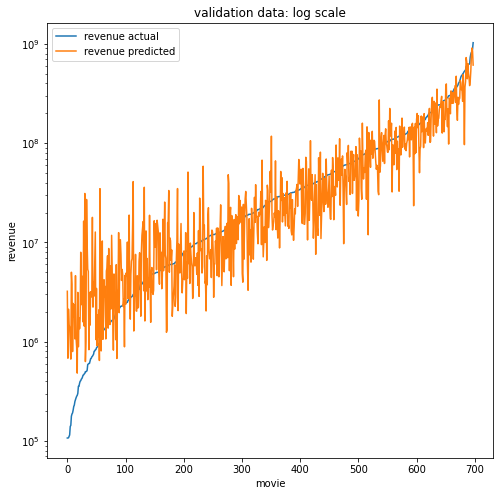

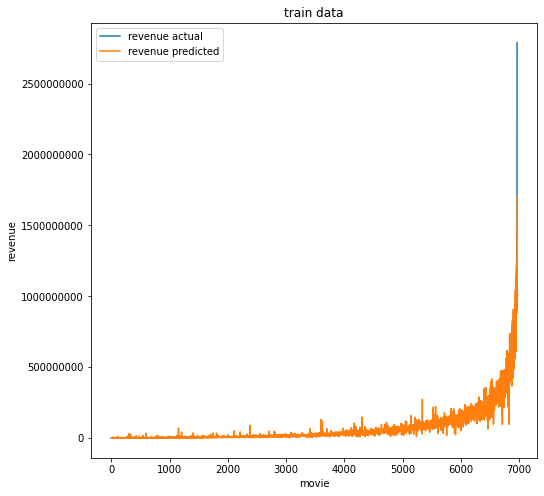

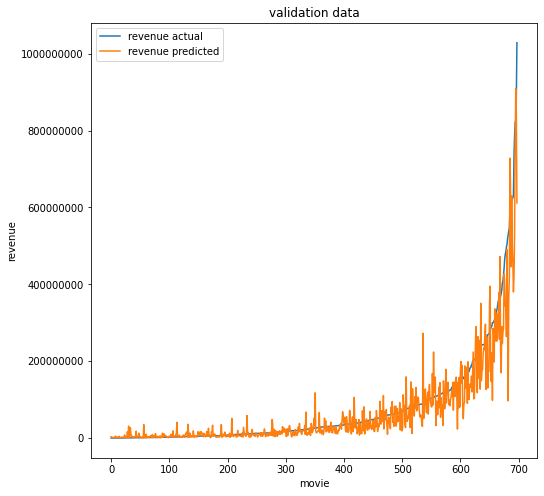

split 4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[684]	valid_0's l1: 8.1147e+07	valid_0's l2: 2.69767e+16
model fit time: 12.5453519821167
train
smape: 25.123
mape: 40.012
mae: 11,090,723.000
rmse: 33,316,383.000
adj_r2: 0.943
test
smape: 54.224
mape: 130.364
mae: 22,226,346.000
rmse: 53,967,027.000
adj_r2: 0.787


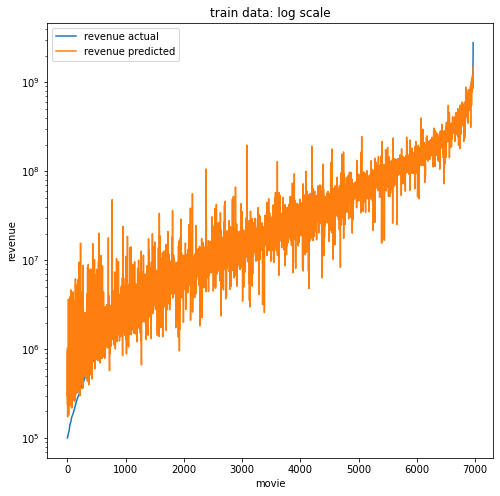

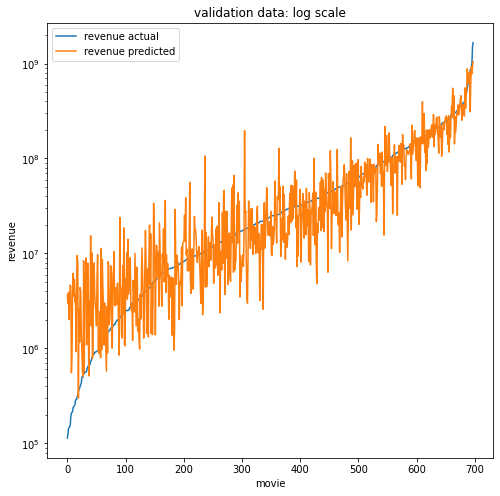

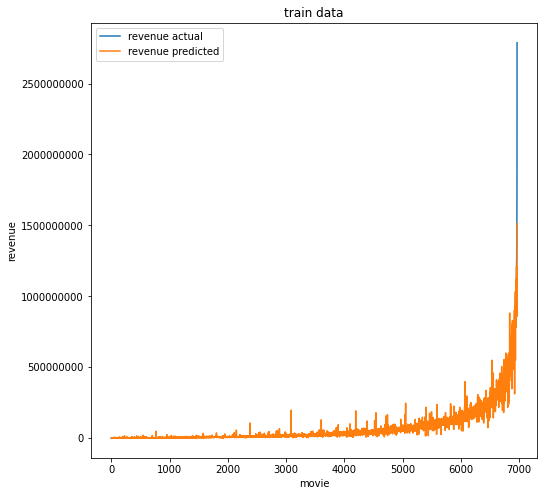

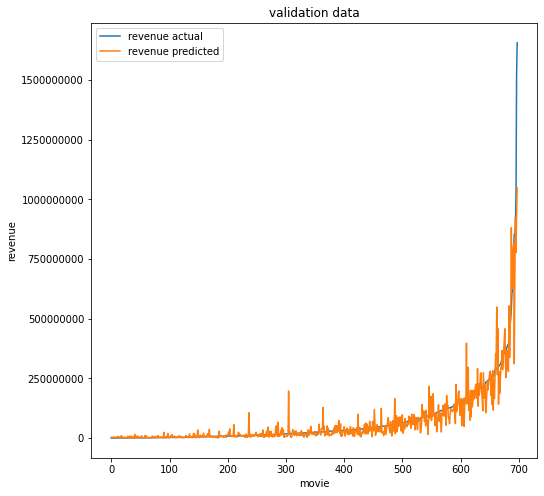

split 5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[521]	valid_0's l1: 8.77681e+07	valid_0's l2: 3.39438e+16
model fit time: 10.50929594039917
train
smape: 29.618
mape: 53.946
mae: 13,321,042.000
rmse: 40,448,751.000
adj_r2: 0.916
test
smape: 54.655
mape: 172.137
mae: 25,967,744.000
rmse: 84,982,452.000
adj_r2: 0.602


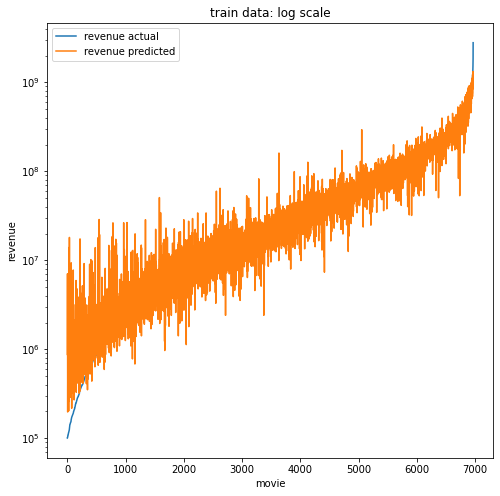

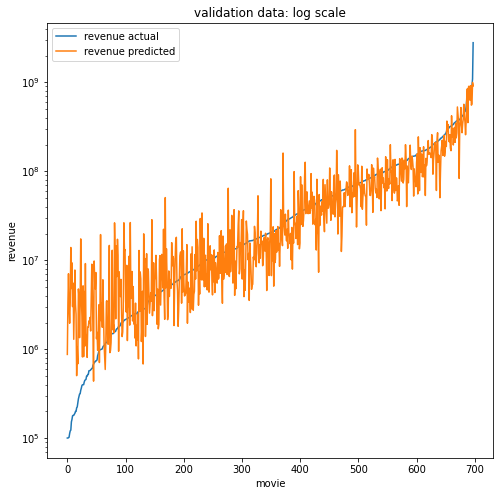

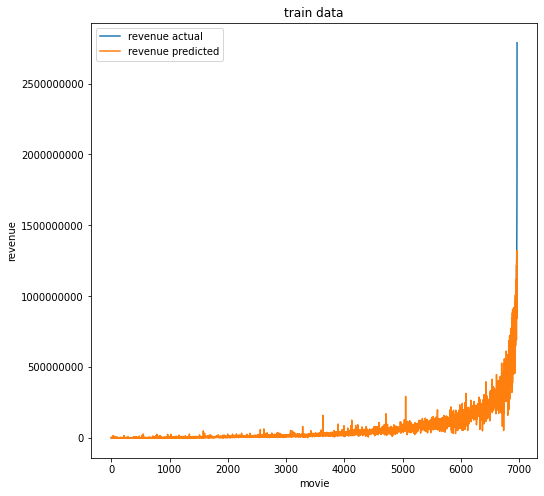

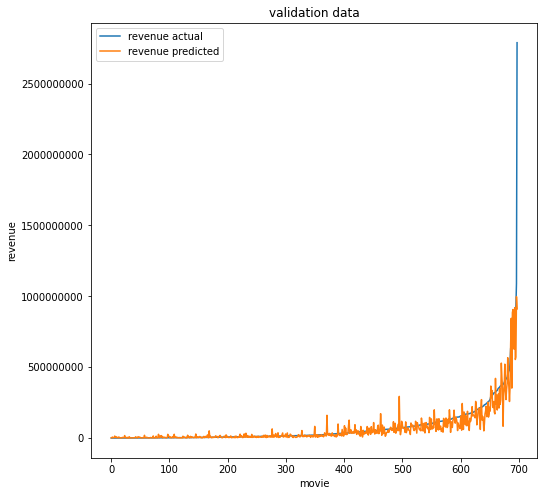

split 6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[732]	valid_0's l1: 6.45896e+07	valid_0's l2: 1.45999e+16
model fit time: 15.319540977478027
train
smape: 24.121
mape: 38.581
mae: 10,835,262.000
rmse: 31,388,064.000
adj_r2: 0.950
test
smape: 53.287
mape: 121.182
mae: 25,964,096.000
rmse: 56,673,852.000
adj_r2: 0.787


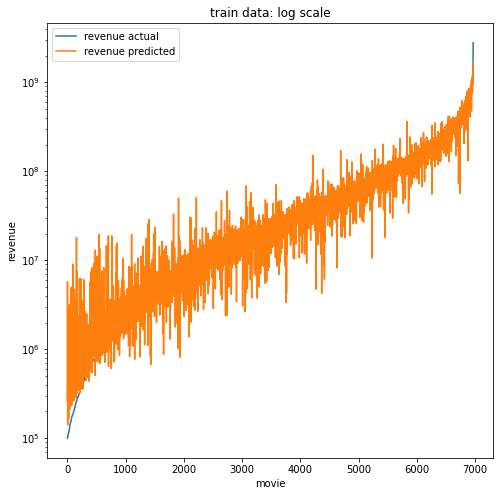

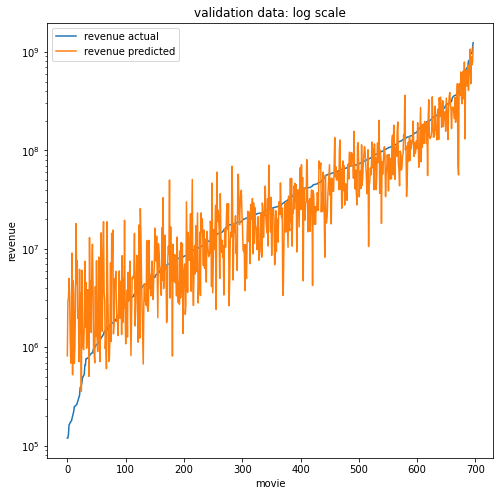

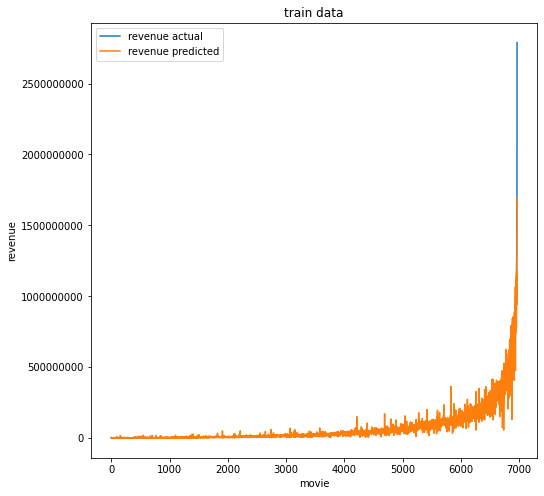

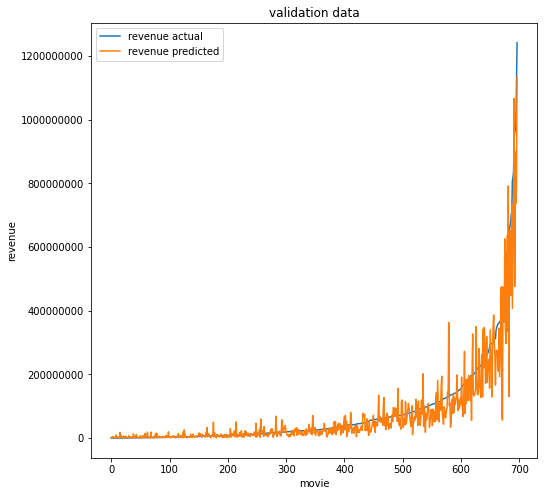

split 7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[595]	valid_0's l1: 7.36992e+07	valid_0's l2: 2.12629e+16
model fit time: 14.290432453155518
train
smape: 27.487
mape: 45.054
mae: 11,998,965.000
rmse: 33,083,328.000
adj_r2: 0.944
test
smape: 53.758
mape: 143.036
mae: 20,875,156.000
rmse: 41,945,838.000
adj_r2: 0.807


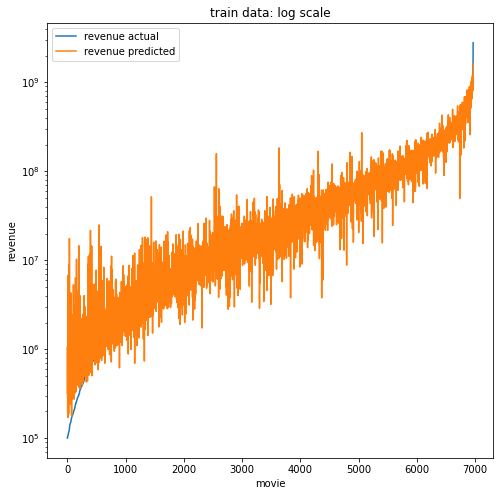

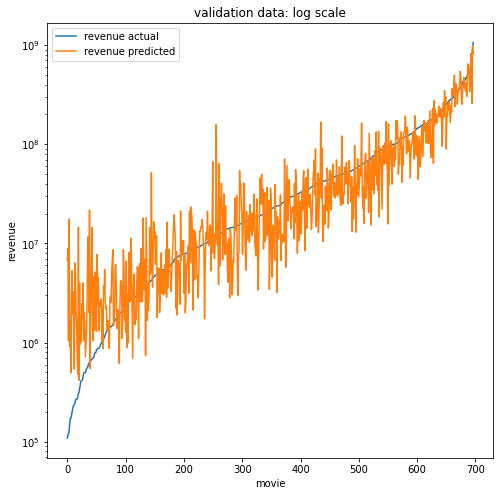

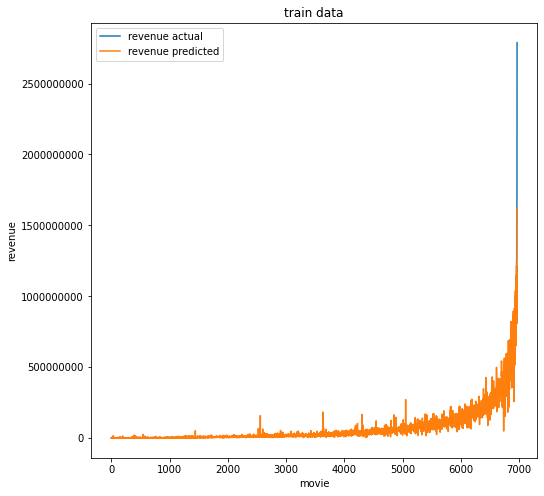

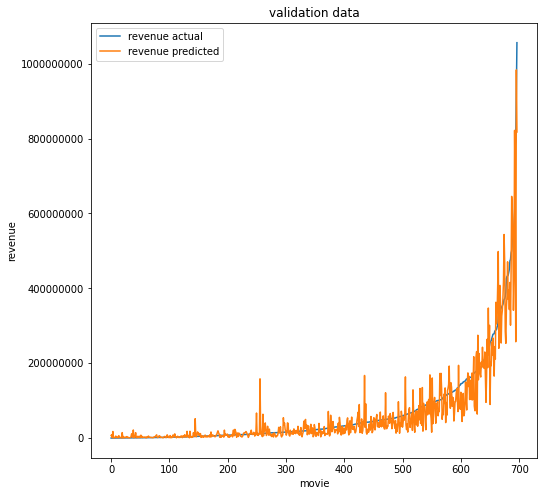

split 8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[647]	valid_0's l1: 7.57311e+07	valid_0's l2: 2.29035e+16
model fit time: 14.044726371765137
train
smape: 26.014
mape: 45.102
mae: 11,725,949.000
rmse: 33,787,185.000
adj_r2: 0.942
test
smape: 53.524
mape: 121.934
mae: 23,617,589.000
rmse: 53,531,102.000
adj_r2: 0.785


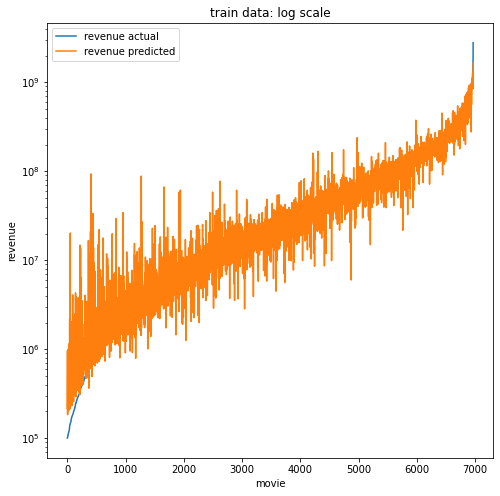

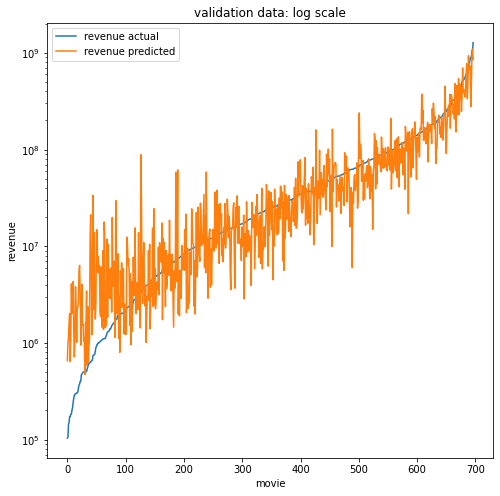

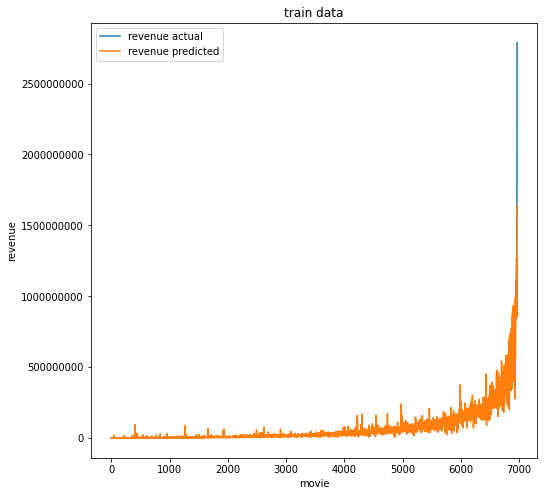

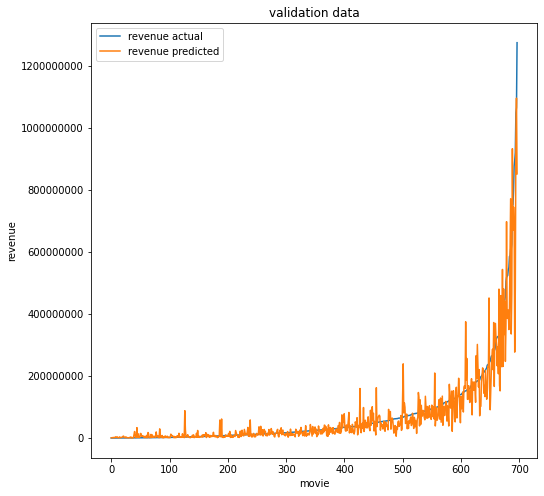

split 9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[503]	valid_0's l1: 8.98299e+07	valid_0's l2: 3.71647e+16
model fit time: 10.502751111984253
train
smape: 30.368
mape: 53.242
mae: 13,681,679.000
rmse: 39,032,701.000
adj_r2: 0.922
test
smape: 56.136
mape: 131.426
mae: 25,264,139.000
rmse: 54,358,472.000
adj_r2: 0.667


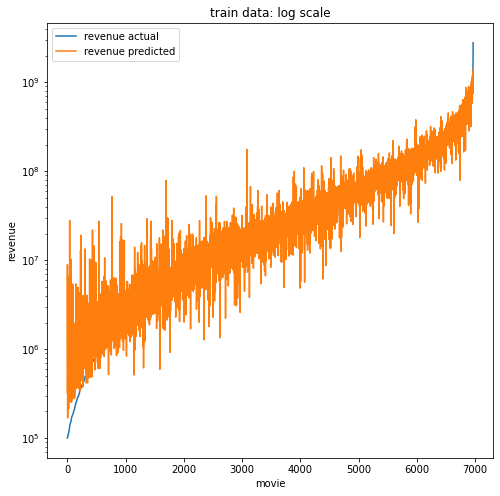

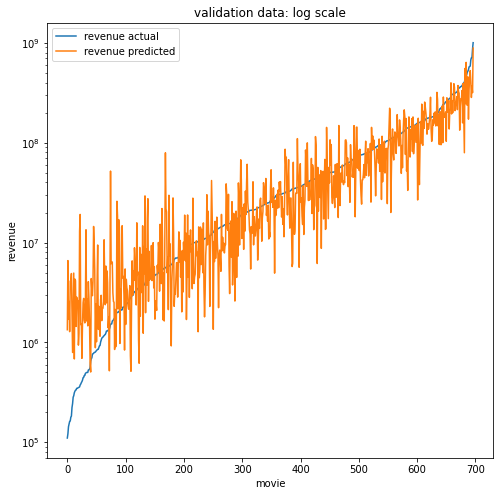

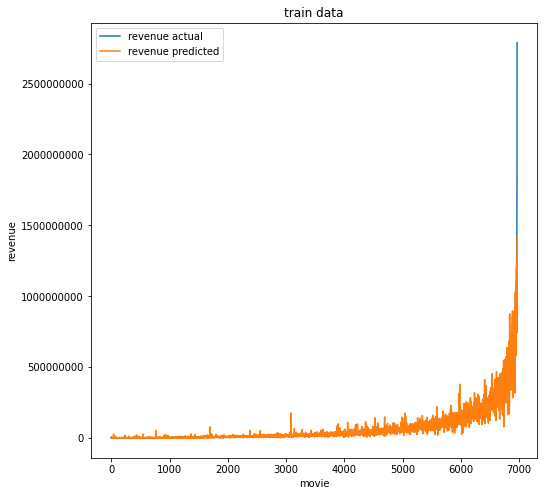

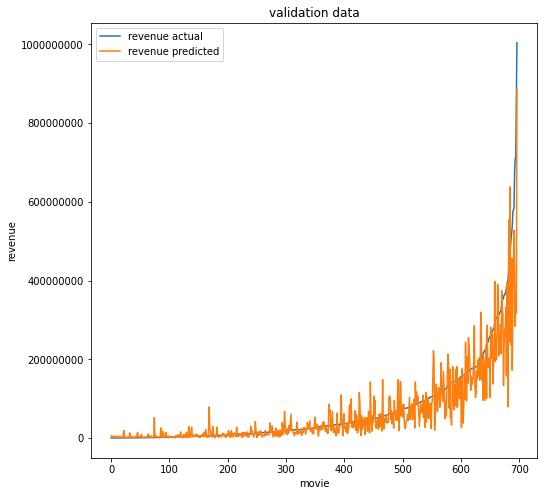

split 10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[604]	valid_0's l1: 6.56466e+07	valid_0's l2: 1.55379e+16
model fit time: 16.207321405410767
train
smape: 27.072
mape: 48.170
mae: 12,246,606.000
rmse: 36,592,427.000
adj_r2: 0.931
test
smape: 52.568
mape: 159.241
mae: 25,706,476.000
rmse: 63,634,526.000
adj_r2: 0.712


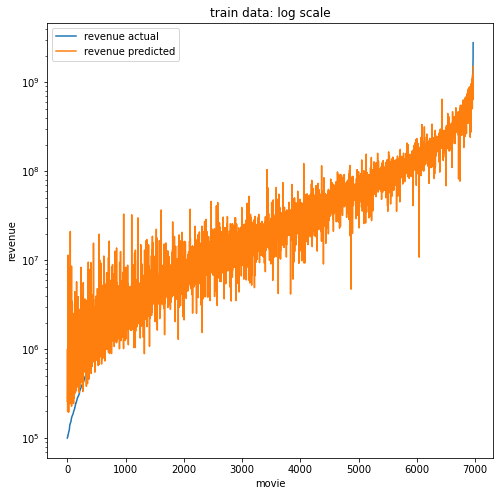

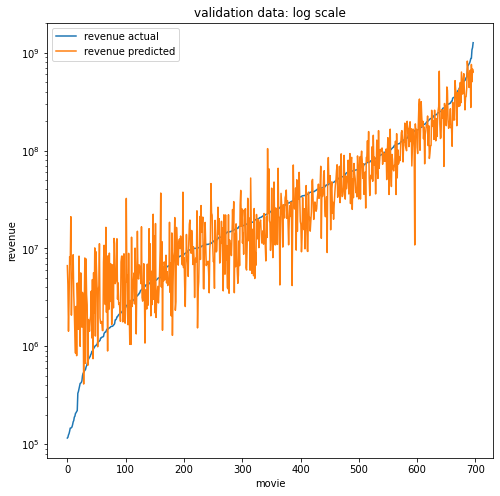

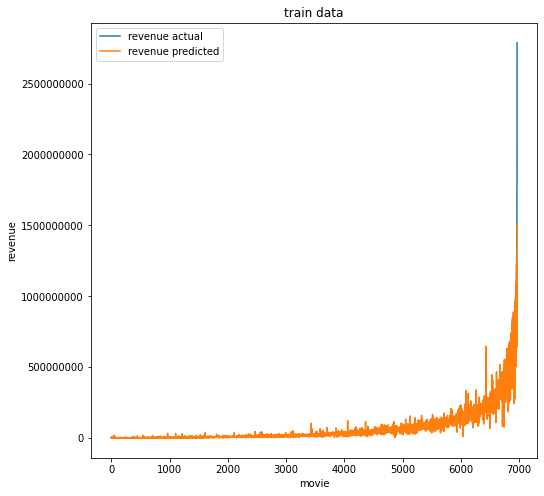

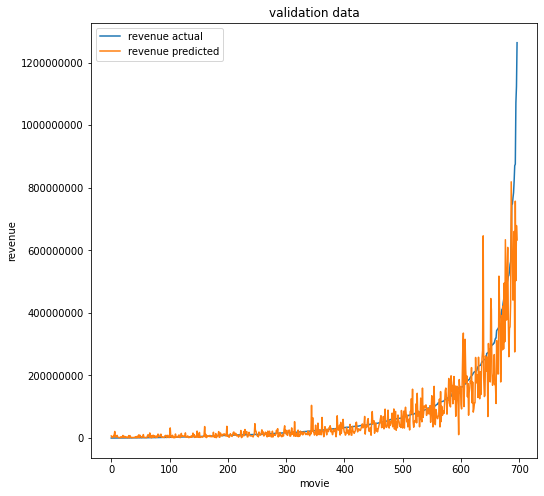

{'smape': 54.7440690257915, 'mape': 150.58145770997874, 'mae': 24564582.8, 'rmse': 58286702.4, 'adj_r2': 0.7449856839330975}
CPU times: user 15min 25s, sys: 4 s, total: 15min 29s
Wall time: 2min 44s


In [33]:
%%time
# tuned with hyperas (30 evals)
cv_result = get_regression_cv_metrics(create_and_fit_lgb_regressor, X, y, 
            n_splits=10, patience=30, validation_size=0.05, regressor_params={}, should_output_graphs=True, should_output_metrics=True)

In [34]:
print_output(cv_result['cv_metrics'])

smape: 54.7440690257915
mape: 150.58145770997874
mae: 24564582.8
rmse: 58286702.4
adj_r2: 0.7449856839330975


split 1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.148 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.665, colsample_bytree=0.984 will be ignored. Current value: feature_fraction=0.665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[765]	valid_0's l1: 6.5961e+07	valid_0's l2: 1.83517e+16
model fit time: 44.34779214859009
split 2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.231 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_ch

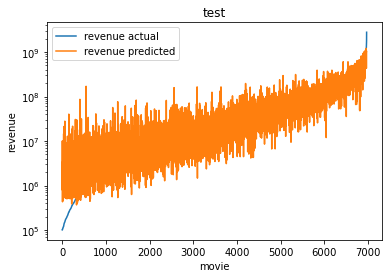

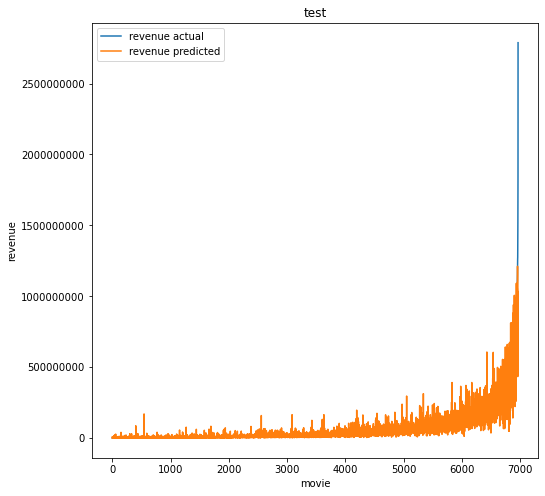

CPU times: user 39min 4s, sys: 36.6 s, total: 39min 41s
Wall time: 6min 39s


In [14]:
%%time
test_true, test_pred = get_regression_cv_predictions(create_and_fit_lgb_regressor, X, y, patience=30)
m = print_metrics(np.array(test_true), np.array(test_pred), X_train.shape[1], 'test')
print_graphs(np.array(test_true), np.array(test_pred), 'test', print_log=True)
print_graphs(np.array(test_true), np.array(test_pred), 'test', print_log=False)

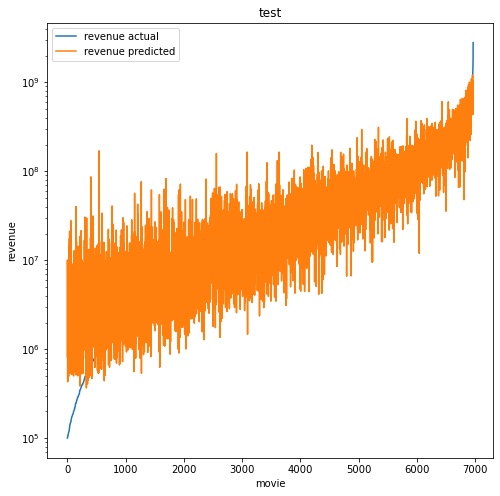

In [15]:
print_graphs(np.array(test_true), np.array(test_pred), 'test', print_log=True)

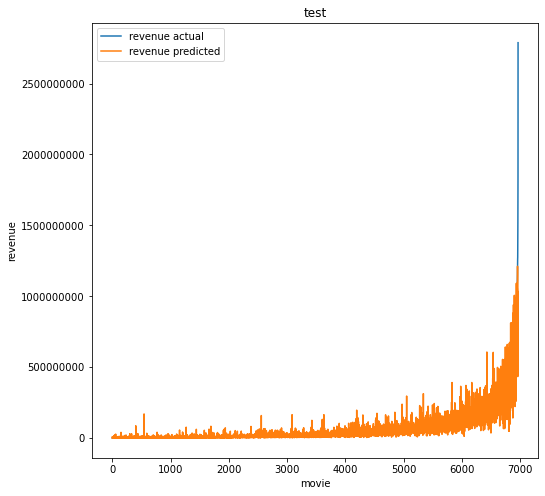

In [16]:
print_graphs(np.array(test_true), np.array(test_pred), 'test', print_log=False)